En este caso, se desea comparar los resultados de un modelo de regresión lineal y un modelo de redes neuronales artificiales.


Usted debe:

* Determinar cuáles de las variables consideradas son relevantes para el problema.


* Determinar si hay alguna transformación de las variables de entrada o de salida que mejore el pronóstico del modelo.


* Construir un modelo de regresión lineal que sirva como base para construir un modelo de redes neuronales artificiales.



* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.

In [1]:
def set_filesystem():
    from google.colab import drive
    from os import chdir
    
    drive.mount('/content/drive/', force_remount=True)
    chdir("/content/drive/My Drive/evaluacion-lfsalazarz")
    
#set_filesystem()

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.compose import TransformedTargetRegressor

%matplotlib inline

# 1. Conjunto de Datos

In [164]:
df = pd.read_csv('datos/diabetes.csv')
print(f'Muestras: {df.shape[0]} Características: {df.shape[1] - 1}')

X = df.drop(['Y'], axis=1)
y = df['Y']

df.head()

Muestras: 442 Características: 10


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


# 2. Modelos base

In [165]:
def evaluate_model_crossval(model, X, y, cv=5, seed=12345):
    kfold = KFold(n_splits=10, random_state=seed)
    scores = cross_val_score(model, X, y, cv=kfold)
    print(f'Cross-val score R2: {scores.mean():0.2f} (+/- {(scores.std() * 2):0.2f})')
    
    
def evaluate_model(model, X, y, di=0, df=350):
    y_pred = model.predict(X)    
    diag = np.linspace(di, df, 100)
    plt.figure(figsize=(7,7))
    plt.title(f'MSE: {mean_squared_error(y, y_pred):.2f}, R2: {r2_score(y, y_pred):.2f}')
    plt.xlabel('y')
    plt.ylabel('y_pred')
    plt.plot(y, y_pred, 'o', markersize=3)
    plt.plot(diag, diag);
    plt.show();

## 2.1. Promedio

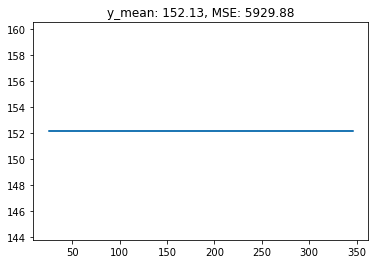

In [170]:
y_naive = y.mean()
y_naive_v = np.repeat(y_naive, len(y))
mse = mean_squared_error(y, y_naive_v)
plt.title(f'y_mean: {y_naive:.2f}, MSE: {mse:.2f}')
#plt.hlines(y_naive, 0, 442);
#plt.ylim([0, 300])
plt.plot(y, y_naive_v);

## 2.2. Regresión lineal base

Cross-val score R2: 0.46 (+/- 0.29)


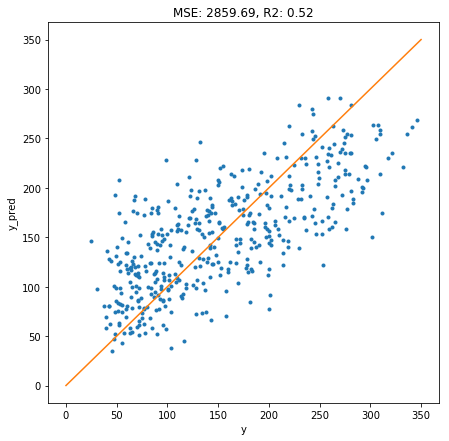

In [171]:
lr = LinearRegression()
lr.fit(X, y)
evaluate_model_crossval(lr, X, y)
evaluate_model(lr, X, y)

# 3. Transformación y selección de características

# 4. Redes neuronales

In [98]:
from sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#lr = LinearRegression()
#lr.fit(X_train, y_train)
#evaluate_model_crossval(lr, X, y)
#evaluate_model(lr, X_test, y_test)


R2: 0.46 (+/- 0.31)
MSE: 2896.34
R2: 0.51


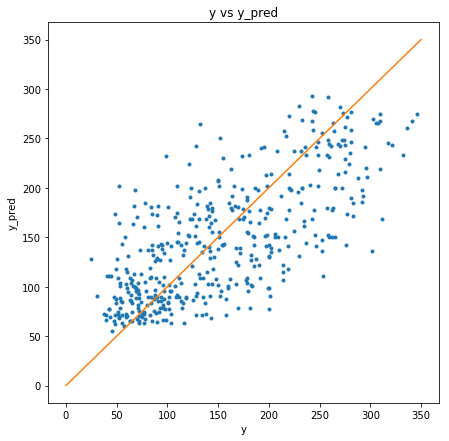

In [92]:
regr_trans = TransformedTargetRegressor(regressor=RidgeCV(), transformer=QuantileTransformer(output_distribution='normal'))
regr_trans.fit(X, y)

evaluate_model_crossval(regr_trans, X, y)
evaluate_model(regr_trans, X, y)

R2: 0.45 (+/- 0.28)
MSE: 2960.24
R2: 0.50


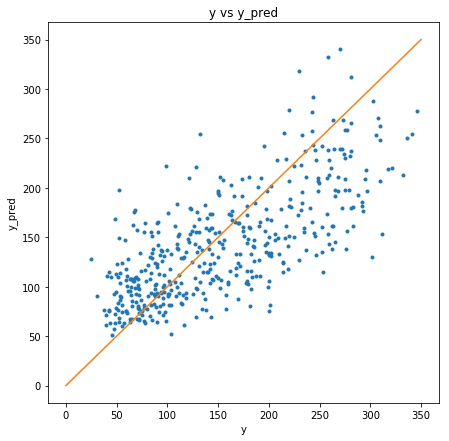

In [66]:
#tt = TransformedTargetRegressor(regressor=LinearRegression(), func=np.sqrt, inverse_func=np.square)
#tt.fit(X, y) 
#tt.score(X, y)
#tt.predict(X)

tt = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1)
tt.fit(X, y) 

evaluate_model_crossval(tt, X, y)
evaluate_model(tt, X, y)

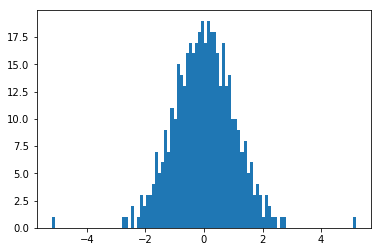

In [88]:
from sklearn.preprocessing import QuantileTransformer, quantile_transform

y_trans = quantile_transform(y.values.reshape(-1, 1), output_distribution='normal').squeeze()

plt.hist(y_trans, bins=100);

R2: 0.41 (+/- 0.27)
MSE: 0.58
R2: 0.47


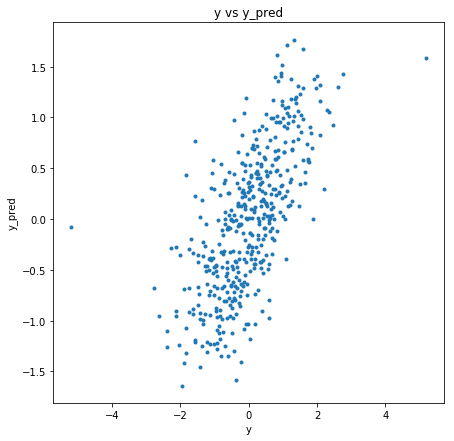

In [89]:
model = LinearRegression()
model.fit(X, y_trans)
evaluate_model_crossval(model, X, y_trans)
evaluate_model(model, X, y_trans)

https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html  
https://machinelearningmastery.com/power-transform-time-series-forecast-data-python/  
https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html  

R2: 0.47 (+/- 0.28)
MSE: 2820.53
R2: 0.52


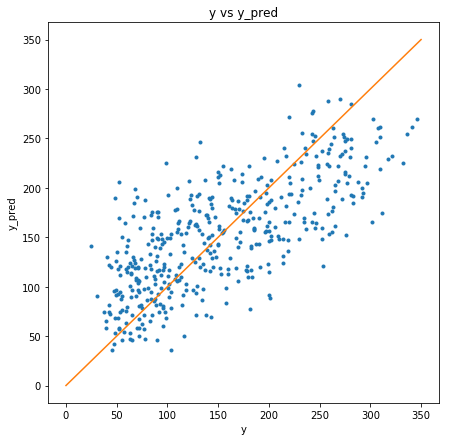

In [0]:
df2 = df.copy()
df2['age'] = np.square(df2['age'])

evaluate_model_crossval(df2.drop(['Y'], axis=1).values, df2['Y'].values)
evaluate_model(df2.drop(['Y'], axis=1).values, df2['Y'].values)

R2: 0.46 (+/- 0.27)
MSE: 0.50
R2: 0.50


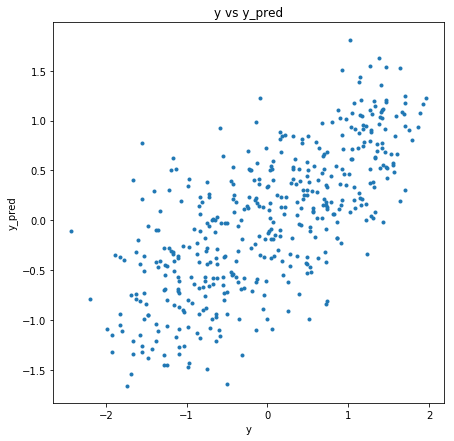

In [0]:
from sklearn.preprocessing import PowerTransformer

df2 = df.copy()
df2['age'] = np.square(df2['age'])
boxcox = PowerTransformer()
x_transformed = boxcox.fit_transform(df2)

evaluate_model_crossval(x_transformed[:,0:-1], x_transformed[:,-1])
evaluate_model(x_transformed[:,0:-1], x_transformed[:,-1])
#x_transformed[:,-1]
#evaluate_model_crossval(x_transformed, df['Y'].values)
#evaluate_model(df.drop(['Y'], axis=1).values, df['Y'].values)